In [1]:
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import warnings
warnings.filterwarnings("ignore")
import os
from tqdm import tqdm
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%load_ext autoreload 
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import gym
import os.path as osp
import sys
sys.path.append("../")
from collections import deque

# from configs.argments import *
from configs.config import *
from models.encoder_decoder import Encoder, Decoder, LargeEncoder, LargeDecoder
from models.discriminator import TrajDiscriminator, StateDistributionDiscriminator, ImgDiscriminator
from models.mapping_func import Real2Sim, Sim2Real, Embedding, MlpEncoder
from models.transition import Transition, TransitionLearner, TransitionDecoder
from models.variance_seq import VarSeq

from stable_baselines import PPO2
from stable_baselines.common.vec_env.vec_normalize import VecNormalize

from utils.env_wrapper import make_vec_env, GeneratorWrapper, is_dapg_env
from utils.transition_helper import sample_next_batch_data, sample_sim_training_data, safe_one_step_transition, obs_acs_reshape
from utils.policy_wrapper import PolicyWrapper
from utils.rollout import Runner

from utils.mujoco_dset import Mujoco_Dset
from utils.util import *
from utils.replay_buffer import TrajectoryBuffer
import mj_envs
from reset_able_mj_env.hopper_v4 import HopperEnv

## argpaser

In [2]:
args = {'seed': 88, 'task': '', 'env_id': 'Hopper-v4', 'auto_env_map': True, 'pretrain_path': '../data/saved_model/transition_weights.npy', 'pretrain_mean_std': '../data/saved_model/state_mean_std.npy', 'policy_timestep': 1000000, 'collect_trajs': 600, 'alg_type': 'codas', 'cycle_loss': False, 'info': '', 'traj_limitation': -1, 'expert_perf_eval_times': 100, 'action_noise_level': 0.0, 'dynamic_param': 1.0, 'load_data': '', 'load_task': '', 'max_sequence': 500, 'max_tf_util': 1.0, 'rollout_step': 25, 'minibatch_size': -1, 'dis_test': False, 'deter_policy': False, 'label_image_test': False, 'dynamic_test': False, 'use_dataset_mean_std': False, 'exact_consist': False, 'ob_transformation': 'img', 'image_size': 64, 'image_channel': 3, 'output_image': True, 'act_fn': 'LeakyReLU', 'dyn_act_fn': 'Tanh', 'layer_norm': True, 'safe_log': False, 'mapping_direction': 'rsr', 'stack_imgs': 1, 'dis_struc': '{oa}', 'rnn_cell': 'GRU', 'disc_hid_dims': [256, 256, 256], 'disc_img_hid_dims': [256], 'dyn_hid_dims': [512, 512, 512], 'disc_emb_hid_dim': 256, 'num_env': 1, 'emb_hid_dims': [256, 256, 256, 256], 'emb_output_size': 256, 'mlp': False, 'clip_acs': True, 'gan_loss': 'minimax', 'r2s_rnn_hid_dims': [128, 128], 'r2s_output_hid_dims': [], 'adjust_allowed': 1.0, 'emb_dynamic': True, 'policy_infer_transition': True, 's2r_hid_dims': [256, 256, 256, 256], 's2r_rnn_hid_dims': [], 's2r_emb_dim': 256, 'reconstruct_clip': -1, 'res_struc': '{r}{as}', 'resc_act_fn': 'Identity', 'real_ob_input': False, 'hard_training': False, 'retrain_dynamics': False, 'filter_traj': False, 'lr_gen': 0.0001, 'lr_dyn': 0.0001, 'dyn_lr_pretrain': 0.0001, 'dyn_l2_loss': 2e-07, 'mapping_l2_loss': 0.0, 'dis_l2_loss': 0.0, 'lr_dis': 5e-05, 'lr_rescale': 1.0, 'dyn_batch_size': 1024, 'mapping_train_epoch': 5, 'dis_train_epoch': 1, 'trajectory_batch': 10, 'decay_ratio': 0.5, 'total_timesteps': 40000, 'lambda_a': 2, 'lambda_b': 0.1, 'norm_std_bound': 0.05, 'stoc_init_range': 0.005, 'grad_clip_norm': 10, 'random_set_to_zero': False, 'data_normalize': True, 'minmax_normalize': False, 'npmap_replace': False, 'merge_d_train': True, 'traj_dis': True, 'clip_policy_bound': True, 'init_first_state': False, 'use_env_sample': True, 'do_save_checkpoint': True, 'pool_size': 6000, 'data_reused_times': 10, 'data_used_fraction': 1, 'use_noise_env': False, 'dual_policy_noise_std': 0.0, 'policy_trainable': False}
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from collections import namedtuple

tmp = namedtuple('args', args.keys())
args = tmp(*list(args.values()))

In [3]:
act_fn = getattr(nn, args.act_fn)
resc_act_fn = getattr(nn, args.resc_act_fn)
dyn_act_fn = getattr(nn, args.dyn_act_fn)
rnn_cell = nn.GRU if args.rnn_cell == 'GRU' else nn.LSTM
print(act_fn, dyn_act_fn, resc_act_fn)

<class 'torch.nn.modules.activation.LeakyReLU'> <class 'torch.nn.modules.activation.Tanh'> <class 'torch.nn.modules.linear.Identity'>


## unitest dataset

In [4]:
## TODO assume the env is not robot env
# DATA_ROOT = '/mnt/e/WPS Cloud Files/MyProject/chengxionghui/CODAS-torch/data'
norm_std_str = '' if args.norm_std_bound == 1 else 'std-{}'.format(args.norm_std_bound)
cpb_str = '' if args.clip_policy_bound else 'ncpb'
img_shape = {ImgShape.WIDTH: args.image_size, ImgShape.HEIGHT: args.image_size, ImgShape.CHANNEL: 3}
OBS_BOUND = 150 if is_dapg_env(args.env_id) else 100

is_robot_env = False


load_path = osp.join(DATA_ROOT, "saved_model")


####################################################################################################################################
#                                                                                                                                  #
#                                                define and reset the environments                                                 #
#                                                                                                                                  #
####################################################################################################################################

model_path = osp.join(load_path, "ppo_{}_{}_full.zip".format(args.env_id, args.policy_timestep))
env_path = osp.join(load_path, "{}_full".format(args.env_id))
if np.abs(args.dual_policy_noise_std - 0.0) > 1e-5:
    real_expert_path = osp.join("../../../", 'dual_{:.02f}_ppo_{}_{}_{}_deter_False_uint8.npz'.
                            format(args.dual_policy_noise_std, args.env_id, args.policy_timestep,
                                    args.collect_trajs))
    sim_expert_path = osp.join("../../../", 'ppo_{}_{}_full_{}_deter_False_uint8_full.npz'.
                            format(args.env_id, args.policy_timestep, args.collect_trajs))
else:
    real_expert_path = sim_expert_path = osp.join("../../../", 'ppo_{}_{}_full_{}_deter_False_uint8_full.npz'.
                            format(args.env_id, args.policy_timestep, args.collect_trajs))
print("\nMake env and real_world_env\n")
env = make_vec_env(args.env_id, num_env=args.num_env, dynamic_param=args.dynamic_param, stoc_init_range=args.stoc_init_range)
env = VecNormalize.load(env_path, env)
env.training = False
env.norm_reward = False

real_world_env = make_vec_env(args.env_id, num_env=args.num_env, dynamic_param=1.0, stoc_init_range=0.005)
real_world_env = VecNormalize.load(env_path, real_world_env)
real_world_env.training = False
real_world_env.norm_reward = False

env = GeneratorWrapper(env)
real_world_env = GeneratorWrapper(real_world_env, use_image_noise=args.use_noise_env)

print("\nMake model\n")
model = PPO2.load(model_path)
dynamics_model_path = osp.join(load_path, f'ppo_{args.env_id}_{args.policy_timestep}_{COLLECT_TRAJ}_network_weights-full'
                                            f'-{args.dynamic_param}-ca-{args.clip_acs}-'
                                            f'dn-{args.data_normalize}{args.minmax_normalize}{norm_std_str}{cpb_str}')
dynamics_model_param_path = osp.join(load_path, f'ppo_{args.env_id}_{args.policy_timestep}_{COLLECT_TRAJ}_'
                                                f'network_weights_param-full-{ args.dynamic_param}-ca-{args.clip_acs}-'
                                                f'dn-{args.data_normalize}{norm_std_str}{cpb_str}')

if args.minmax_normalize:
    dynamics_model_path += '-mn'
    dynamics_model_param_path += '-mm'

dynamics_model_path += '.npy'
dynamics_model_param_path += '.pkl'

runner = Runner(simulator_env=env, real_world_env=real_world_env, sim_policy=model, real_policy=model,
                max_horizon=args.max_sequence, img_shape=img_shape, clip_acs=args.clip_acs, exact_consist=args.exact_consist)

env.reset()
real_world_env.reset()


Make env and real_world_env

Logging to /tmp/openai-2022-04-07-14-59-55-136801
load Hopper environment with dynamic resacle: *1.0
load Hopper environment with dynamic resacle: *1.0
inner mean 0, std 1
inner mean 0, std 1

Make model

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




array([ 1.25437804e+00, -1.02531251e-03, -2.80081367e-03, -4.90458246e-03,
       -1.32321934e-03,  2.81954387e-03,  2.31732639e-03,  1.46272567e-03,
        1.34641158e-04,  2.83660812e-03, -3.55598799e-03])

array([ 1.25010421e+00,  4.70015162e-04,  1.45830060e-03, -2.45480099e-03,
       -2.10096443e-03, -2.50344580e-03,  4.95111847e-03, -1.41366009e-03,
       -4.46310058e-04,  7.85754422e-04, -2.92843192e-03])

In [5]:
print("norm_std_str {}, cpb_str {}, img_shape {}, OBS_BOUND {}".format(norm_std_str, cpb_str, img_shape, OBS_BOUND))
print("env state space", env.state_space)
print("env action space", env.action_space)
print("real_world_env state space", real_world_env.state_space)
print("real_world_env action space", real_world_env.action_space)
print("dynamic model path: ", dynamics_model_path)
print("dynamic model param path: ", dynamics_model_param_path)
print("real expert path: ", real_expert_path)
print("sim expert path: ", sim_expert_path)

norm_std_str std-0.05, cpb_str , img_shape {'width': 64, 'height': 64, 'channel': 3}, OBS_BOUND 100
env state space Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float64)
env action space Box([-1. -1. -1.], [1. 1. 1.], (3,), float32)
real_world_env state space Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float64)
real_world_env action space Box([-1. -1. -1.], [1. 1. 1.], (3,), float32)
dynamic model path:  ../data/saved_model/ppo_Hopper-v4_1000000_600_network_weights-full-1.0-ca-True-dn-TrueFalsestd-0.05.npy
dynamic model param path:  ../data/saved_model/ppo_Hopper-v4_1000000_600_network_weights_param-full-1.0-ca-True-dn-Truestd-0.05.pkl
real expert path:  ../../../ppo_Hopper-v4_1000000_full_600_deter_False_uint8_full.npz
sim expert path:  ../../../ppo_Hopper-v4_1000000_full_600_deter_False_uint8_full.npz


## collect dataset

In [6]:
expert_dataset = Mujoco_Dset(sim_data=False, expert_path=real_expert_path, traj_limitation=args.traj_limitation,
                                 use_trajectory=True, max_sequence=args.max_sequence, env=env,
                                 data_used_fraction=args.data_used_fraction, clip_action=args.clip_acs,
                                 filter_traj=args.filter_traj, npmap_replace=args.npmap_replace)
sim_training_dataset = Mujoco_Dset(sim_data=True, expert_path=sim_expert_path, traj_limitation=-1,
                                use_trajectory=True, max_sequence=args.max_sequence, env=env,
                                data_used_fraction=1.0, clip_action=args.clip_acs, filter_traj=False,
                                    npmap_replace=args.npmap_replace)
expert_dataset.obs_std[expert_dataset.obs_std == 0] = 1
sim_training_dataset.obs_std[sim_training_dataset.obs_std < args.norm_std_bound] = 1

state_mean_std = [sim_training_dataset.obs_mean, sim_training_dataset.obs_std]
if not args.data_normalize:
    state_mean_std[0] = np.zeros(state_mean_std[0].shape)
    state_mean_std[1] = np.ones(state_mean_std[1].shape)

if args.minmax_normalize:
    state_mean_std[0] = sim_training_dataset.obs_min
    state_mean_std[1] = sim_training_dataset.obs_max - sim_training_dataset.obs_min
    state_mean_std[0][state_mean_std[1] == 0] = 0
    state_mean_std[1][state_mean_std[1] == 0] = 1
# state_mean_std = torch.FloatTensor(state_mean_std).to(DEVICE)
env.reset()
real_world_env.reset()

init dataset from ../../../ppo_Hopper-v4_1000000_full_600_deter_False_uint8_full.npz


rews in dataset 2051.796689628644
finished loading raw value
[WARN] 0 : padding length not match current:1002, target:500
[WARN] 0 : padding length not match current:1002, target:500
[WARN] 0 : padding length not match current:1002, target:500
compelte padding
Total trajectorues: 600
Total transitions: 600
Average returns: 2052.540748
Std for returns: 765.534231
obs in ([  0.          -0.18711282  -1.59035656  -0.6252722   -0.97075045
  -0.05207337  -4.72601723  -3.95454654  -6.87794179  -6.72959621
 -10.        ], [ 1.68136646  0.19850551  0.04823523  0.06016413  0.89405415  4.88569685
  3.00571769  3.37718836  6.83281452  8.2080438  10.        ])
acs in ([-1. -1. -1.], [1. 1. 1.])
init dataset from ../../../ppo_Hopper-v4_1000000_full_600_deter_False_uint8_full.npz


rews in dataset 1460.5678888597533
finished loading raw value
[WARN] 0 : padding length not match current:1002, target:500
[WARN] 0 : 

array([ 1.25188926e+00, -7.89739325e-04, -4.74949155e-03,  3.57452435e-03,
        1.59220635e-03,  2.94833424e-03,  2.32924911e-03,  2.01390590e-03,
       -2.80451677e-03, -3.78780106e-03,  1.58052593e-03])

array([ 1.25167216e+00, -1.38058307e-03, -4.13664980e-03,  9.21076363e-04,
        2.10622128e-03,  4.22014029e-03, -4.26124867e-03, -4.11828127e-04,
        1.31580028e-03, -6.83934065e-04,  1.43340073e-04])

In [7]:
print("state_mean_std ", state_mean_std)
print("data normalize ", args.data_normalize)
print("minmax_normalize ", args.minmax_normalize)

state_mean_std  [array([ 0.9542626 ,  0.00963413, -0.37676725, -0.04036831,  0.18012461,
        1.71405167, -0.09029371,  0.01000815, -0.2465167 , -0.08070052,
       -0.03574622]), array([0.58006943, 0.06046504, 0.31641538, 0.0872722 , 0.53100412,
       1.24555214, 1.18027144, 0.75612451, 1.64034753, 1.17309253,
       5.26985916])]
data normalize  True
minmax_normalize  False


## pretrain the dynamic model

### normalization

In [8]:
## define the normalize range
if args.clip_policy_bound:
    norm_min = data_normalization(np.clip(sim_training_dataset.obs_min, -1 * OBS_BOUND, OBS_BOUND), state_mean_std)
    norm_max = data_normalization(np.clip(sim_training_dataset.obs_max, -1 * OBS_BOUND, OBS_BOUND), state_mean_std)
else:
    norm_min = data_normalization(sim_training_dataset.obs_min, state_mean_std)
    norm_max = data_normalization(sim_training_dataset.obs_max, state_mean_std)

norm_range = norm_max - norm_min

epsilon_expanded = 0.05
update_dynamics_range_min = norm_min - epsilon_expanded * norm_range
update_dynamics_range_max = norm_max + epsilon_expanded * norm_range
update_dynamics_range_min_trans_learn = norm_min - (epsilon_expanded - 1e-3) * norm_range
update_dynamics_range_max_trans_learn = norm_max + (epsilon_expanded - 1e-3) * norm_range

In [9]:
print("norm_min {}, norm_max {}".format(norm_min, norm_max))
print(update_dynamics_range_max, update_dynamics_range_min, update_dynamics_range_max_trans_learn, update_dynamics_range_min_trans_learn)

norm_min [-1.6450834  -3.46645651 -3.87919098 -9.80860217 -2.16735619 -1.53596508
 -4.08582684 -6.65063036 -4.70447544 -5.90737349 -1.89080077], norm_max [1.46430506 3.14834958 1.34857707 1.18055395 1.45462011 2.85336941
 2.87239158 7.49681701 5.1762147  7.14344223 1.90436707]
[1.61977448 3.47908989 1.60996547 1.73001176 1.63571892 3.07283614
 3.2203025  8.20418938 5.67024921 7.79598302 2.09412546] [ -1.80055282  -3.79719681  -4.14057938 -10.35805997  -2.348455
  -1.75543181  -4.43373776  -7.35800273  -5.19850994  -6.55991427
  -2.08055917] [1.61666509 3.47247508 1.6047377  1.7190226  1.63209694 3.06844681
 3.21334429 8.19004193 5.66036852 7.7829322  2.09033029] [ -1.79744343  -3.79058201  -4.13535161 -10.34707082  -2.34483303
  -1.75104247  -4.42677954  -7.34385528  -5.18862925  -6.54686346
  -2.076764  ]


In [10]:
pool_size = int(args.pool_size if args.pool_size > 0 else args.trajectory_batch * args.data_reused_times * 1000)
trajecory_buffer = TrajectoryBuffer(pool_size, has_img=False)
mapping_train_epoch = args.mapping_train_epoch

total_timesteps = args.total_timesteps
adjust_allowed = args.adjust_allowed
discriminator_train_epochs = args.dis_train_epoch
pool_size, mapping_train_epoch, total_timesteps, adjust_allowed, discriminator_train_epochs

(6000, 5, 40000, 1.0, 1)

### test runner run_traj

In [11]:
rews = []
for i in tqdm(range(args.expert_perf_eval_times)):
    ret_dict = runner.run_traj(deter=False, mapping_holder=None, render_img=False,
                                run_in_realworld=True)
    while ret_dict[runner.TRAJ_LEN] == 0:
        ret_dict = runner.run_traj(deter=False, mapping_holder=None, render_img=False,
                                    run_in_realworld=True)
    rews.append(ret_dict[runner.TOTAL_REW])
expert_reward = np.mean(rews)

if is_dapg_env(args.env_id):
    if args.env_id == 'pen-v0':
        expert_reward_lower_bound_assert = expert_dataset.avg_ret * ((args.max_sequence * 0.8) / 200)
    else:
        expert_reward_lower_bound_assert = expert_dataset.avg_ret * ((args.max_sequence * 0.6) / 200)
else:
    expert_reward_lower_bound_assert = expert_dataset.avg_ret * ((args.max_sequence * 0.8) / 1000)

assert expert_reward_lower_bound_assert < expert_reward, "dataset perf: {}, runner perf: {} < {}".\
    format(expert_dataset.avg_ret, expert_reward, expert_reward_lower_bound_assert)

100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


In [12]:
for k, v in ret_dict.items():
    if type(v) is np.ndarray:
        print(k, v.shape)
    else:
        print(k, v)

total_rew 1650.192925472934
traj_len 499
ob_traj (500, 11)
ac_traj (500, 3)
r2s_ob_traj (500, 11)
img_traj (500, 64, 64, 3)
dones_traj (500,)


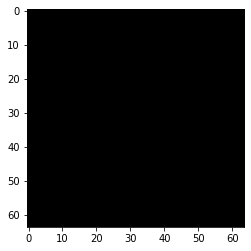

In [20]:
import matplotlib.pyplot as plt
plt.imshow(ret_dict['img_traj'][0])

In [13]:
print("expert reward ", expert_reward)
print("expert_dataset.avg_ret ", expert_dataset.avg_ret)
print("expert_reward_lower_bound_assert ", expert_reward_lower_bound_assert)

expert reward  1191.7237237219113
expert_dataset.avg_ret  2052.5407476369023
expert_reward_lower_bound_assert  821.016299054761


### pretrain

In [14]:
# define the transition moodels
if args.emb_dynamic:
    transition = Transition(transition_hidden_dims=args.dyn_hid_dims, transition_trainable=True,
                                        ob_shape=env.state_space.shape[0], ac_shape=env.action_space.shape[0], act_fn=dyn_act_fn,  
                                        obs_min=update_dynamics_range_min,
                                        obs_max=update_dynamics_range_max).to(DEVICE)
    transition_target = Transition(transition_hidden_dims=args.dyn_hid_dims, transition_trainable=False,
                                        ob_shape=env.state_space.shape[0], ac_shape=env.action_space.shape[0], act_fn=dyn_act_fn,  
                                        obs_min=update_dynamics_range_min,
                                        obs_max=update_dynamics_range_max).to(DEVICE)
    transition_learner = TransitionLearner(transition=transition, transition_target=transition_target, 
                                            ob_shape=env.state_space.shape[0], ac_shape=env.action_space.shape[0], 
                                            lr=args.lr_dyn, batch_size=args.dyn_batch_size, l2_loss=args.dyn_l2_loss).to(DEVICE)
    transition_decoder_input_size = args.r2s_rnn_hid_dims[-1] + env.state_space.shape[0] + 256 + env.action_space.shape[0]
    transition_decoder = TransitionDecoder(ob_shape=env.state_space.shape[0], input_size=transition_decoder_input_size,
                                               hidden_dims=args.r2s_output_hid_dims,
                                               obs_min=update_dynamics_range_min,
                                               obs_max=update_dynamics_range_max).to(DEVICE)
else:
    transition = None
    transition_learner = None
    transition_decoder = None

In [15]:
dynamics_model_path = './m.pkl'
dynamics_model_param_path = './lr.pkl'

In [16]:
adjust_allowed = args.adjust_allowed

max_error_list = deque(maxlen=50)
max_error_list.append(np.inf)
inc_batch_counter = 0

break_counter = 0
inc_batch_counter = 0
counter = 0
while True:
    obs_real, _, acs_real, lengths = sample_sim_training_data(args, sim_training_dataset, OBS_BOUND, state_mean_std, traj_batch_size=100)
    obs_train, acs_train, obs_next_train = obs_acs_reshape(obs_real, acs_real)

    mse_loss, max_error, l2_reg = transition_learner.update_transition(obs_train, acs_train, obs_next_train, lr=args.dyn_lr_pretrain)
    if counter % 50 == 0:
        transition_learner.copy_params_to_target()

    inc_batch_counter = inc_batch_counter + 1 if np.min(max_error_list) <= max_error else 0
    max_error_list.append(max_error)

    if inc_batch_counter >= 200 and counter > 100000: # store the weights
        inc_batch_counter = 0
        transition_learner.transition.save(dynamics_model_path)
        with open(dynamics_model_param_path, 'wb') as f:
            pickle.dump({"lr": transition_learner.lr}, file=f)
        break
    
    if counter > 10:
        break
    
    if counter % 1000 == 1: # store the weights
        transition_learner.transition.save(dynamics_model_path)
        with open(dynamics_model_param_path, 'wb') as f:
            pickle.dump({"lr": transition_learner.lr}, file=f)

    break_counter += 1 if max_error < (adjust_allowed * 0.8)**2 else 0
    if break_counter >= 20 and counter > 100000:
        break
    counter += 1
    print("Counter {}\tmse_loss {:.4f}\tmax_error {:.4f}\tl2_reg {:.4f}".format(counter, mse_loss, max_error, l2_reg))

Counter 1	mse_loss 0.5912	max_error 12.7969	l2_reg 516.0572
Counter 2	mse_loss 0.0684	max_error 6.4876	l2_reg 516.8673
Counter 3	mse_loss 0.0463	max_error 6.2499	l2_reg 516.9283
Counter 4	mse_loss 0.0383	max_error 6.1379	l2_reg 517.0185
Counter 5	mse_loss 0.0364	max_error 7.0845	l2_reg 517.0982
Counter 6	mse_loss 0.0341	max_error 6.1722	l2_reg 517.1525
Counter 7	mse_loss 0.0314	max_error 5.7417	l2_reg 517.1612
Counter 8	mse_loss 0.0304	max_error 6.3774	l2_reg 517.1764
Counter 9	mse_loss 0.0298	max_error 5.1782	l2_reg 517.1817
Counter 10	mse_loss 0.0273	max_error 5.4623	l2_reg 517.1894
Counter 11	mse_loss 0.0282	max_error 6.5332	l2_reg 517.2554


## Train the discriminator and generator

### construct model

In [17]:
# define the discriminator
if args.gan_loss == GanLoss.MINIMAX:
    if args.traj_dis: ## judge whether the discriminator is applied on trajectory or statedistribution
        discriminator = TrajDiscriminator(input_size=env.state_space.shape[0]+env.action_space.shape[0], hid_dims=args.disc_hid_dims, emb_hid_dim=args.disc_emb_hid_dim, output_size=1, discre_struc=args.dis_struc, layer_norm=False, rnn_cell=rnn_cell, rnn_hidden_dims=[128]).to(DEVICE)
    else:
        state_dis_input_size = env.state_space.shape[0] if args.dis_struc == DiscriminatorStructure.OB else env.state_space.shape[0] + env.action_space.shape[0]
        discriminator = StateDistributionDiscriminator(input_size=state_dis_input_size, hid_dims=args.disc_hid_dims, emb_hid_dim=args.disc_emb_hid_dim, output_size=1, discre_struc=args.dis_struc, layer_norm=False, rnn_cell=rnn_cell, rnn_hidden_dims=[128]).to(DEVICE)
elif args.gan_loss == GanLoss.WGAN:
    state_dis_input_size = env.state_space.shape[0] if args.dis_struc == DiscriminatorStructure.OB else env.state_space.shape[0] + env.action_space.shape[0]
    discriminator = StateDistributionDiscriminator(input_size=state_dis_input_size, hid_dims=args.disc_hid_dims, emb_hid_dim=args.disc_emb_hid_dim, output_size=1, discre_struc=args.dis_struc, layer_norm=False, act_fn=nn.LeakyReLU).to(DEVICE)
else:
    raise NotImplementedError

img_discriminator = ImgDiscriminator(input_size=img_shape[ImgShape.HEIGHT],hid_dims=args.disc_img_hid_dims, emb_hid_dim=args.disc_emb_hid_dim, output_size=1, discre_struc=args.dis_struc, layer_norm=args.layer_norm).to(DEVICE)

In [18]:
encoder = Encoder(stack_imgs=args.stack_imgs).to(DEVICE)
obs_output_size = get_output_size(encoder, [args.max_sequence]+list(img_shape.values()), dims=[-1])
ac_shape = env.action_space.shape[0]
img_shape_to_list = [img_shape[ImgShape.WIDTH], img_shape[ImgShape.HEIGHT], img_shape[ImgShape.CHANNEL]]
acs_output_size = ac_shape
embedding = Embedding(input_size=obs_output_size+acs_output_size, hidden_dims=args.emb_hid_dims, output_size=args.emb_output_size, act_fn=act_fn, layer_norm=args.layer_norm).to(DEVICE)
mlp = None # MlpEncoder(input_size=14, hidden_dims=args.dyn_hid_dims, act_fn=nn.Tanh).to(DEVICE)

real2sim_input_size = 256 + env.state_space.shape[0] + env.action_space.shape[0]  if args.emb_dynamic else 256
real2sim = Real2Sim(input_size=real2sim_input_size, rnn_hidden_dims=args.r2s_rnn_hid_dims, rnn_cell=rnn_cell, seq_length=args.max_sequence, act_fn=act_fn, ob_shape=env.state_space.shape[0], action_shape=env.action_space.shape[0], mlp_layer=mlp, output_hidden_dims=args.r2s_output_hid_dims, layer_norm=args.layer_norm, emb_dynamic=args.emb_dynamic, transition=transition, transition_decoder=transition_decoder, target_mapping=False, num_gan_step=1, device='cuda').to(DEVICE)

sim2real_real_input_size = 256 if args.real_ob_input else env.state_space.shape[0]
sim2real_real2sim_input_size = env.state_space.shape[0] + env.action_space.shape[0] if args.res_struc == ResnetStructure.EMBEDDING_RAS else env.state_space.shape[0]
sim2real = Sim2Real(real_input_size=sim2real_real_input_size, real2sim_input_size=sim2real_real2sim_input_size, hidden_dims=args.s2r_emb_dim, rnn_hidden_dims=args.s2r_rnn_hid_dims, rnn_cell=rnn_cell, emb_dim=args.s2r_emb_dim, ob_shape=env.state_space.shape[0], ac_shape=env.action_space.shape[0], layer_norm=args.layer_norm, res_struc=args.res_struc, act_fn=resc_act_fn, real_ob_input=args.real_ob_input, device='cuda').to(DEVICE)

if args.image_size == 64:
    encoder = Encoder(stack_imgs=args.stack_imgs).to(DEVICE)
    decoder = Decoder(input_size=256, output_size=img_shape[ImgShape.CHANNEL]).to(DEVICE)
else:
    assert args.image_size == 128
    encoder = LargeEncoder(stack_imgs=args.stack_imgs).to(DEVICE)
    decoder = LargeDecoder().to(DEVICE)


## define the variance sequence model
var_seq = VarSeq(sequence_length=args.max_sequence, img_shape=img_shape,
                     embedding=embedding, real2sim_mapping=real2sim, sim2real_mapping=sim2real,
                     discriminator=discriminator, obs_discriminator=img_discriminator,
                     encoder=encoder, decoder=decoder,
                     batch_size=args.trajectory_batch,
                     lambda_a=args.lambda_a, lambda_b=args.lambda_b,
                     ac_shape=env.action_space.shape[0], ob_shape=env.state_space.shape[0],
                     lr_dis=args.lr_dis, lr_gen=args.lr_gen,
                     total_timesteps=args.total_timesteps, decay_ratio=args.decay_ratio,
                     grad_clip_norm=args.grad_clip_norm,
                     dis_test=args.dis_test, label_image_test=args.label_image_test,
                     reconstruct_clip=args.reconstruct_clip,
                     emb_dynamic=args.emb_dynamic, rollout_step=args.rollout_step,
                     cycle_loss=args.cycle_loss, minibatch_size=args.minibatch_size, merge_d_train=args.merge_d_train,
                     stack_imgs=args.stack_imgs, random_set_to_zero=args.random_set_to_zero,
                     init_first_state=args.init_first_state, l2_coeff=args.mapping_l2_loss,
                     dis_l2_coeff=args.dis_l2_loss)

### infer the correspongding trajectories via the mapping function f

In [19]:
total_timesteps = args.total_timesteps
discriminator_train_epochs = args.dis_train_epoch

start_epoch = 0
mapping_train_epochs = 20
too_strong_discriminator = False
for it in range(start_epoch, total_timesteps):
    ## sample a batch of target domain trajectories real traj = {(o0,a0,o1,a1,...)} from real dataset
    obs_real, imgs_real, acs_real, lengths, dones = sample_next_batch_data(args, runner, expert_dataset, trajecory_buffer, OBS_BOUND, state_mean_std, LossType.VAE, it)
    obs_sim, _, acs_sim, lengths, dones = sample_next_batch_data(args, runner, expert_dataset, trajecory_buffer, OBS_BOUND, state_mean_std, LossType.GAN, it)
    
    ## infer the corresponding state trajectories sim traj = {(s^hat_1, ..., s^hat_T)} via the mapping function f
    res_infer_dict = var_seq.infer_data(S_r=obs_real, O_r=imgs_real, A_r=acs_real, S_sim=obs_sim, A_sim=acs_sim, adjust_allowed=adjust_allowed)

    var_length, var_length_sim = res_infer_dict['var_length'], res_infer_dict['var_length_sim']
    all_hidden_state, all_cycle_hidden_state = res_infer_dict['all_hidden_state'], res_infer_dict['all_cycle_hidden_state']
    ob_real2sim = res_infer_dict['hat_S_r_mask'] # core returns

    # no need to perform full_state_to_state here because no obs are fed into networks
    ## rollout one step with the oracle simulation dynamics p(s'|s, a) for each state-action pair in sim traj 
    ## to construct the transition dataset D_{s^hat}={(s^hat_i, a_i, s_{i+1})}
    O_r_rollout, O_r_first, A_r_rollout, A_r_first, A_sim_rollout, A_sim_first, S_sim_rollout, S_r_rollout, prev_hidden_state, prev_cycle_hidden_state = var_seq.preprocess_data(S_r=obs_real, O_r=imgs_real, A_r=acs_real, S_sim=obs_sim, A_sim=acs_sim, var_length=var_length,  var_length_sim=var_length_sim, all_hidden_state=all_hidden_state, all_cycle_hidden_state=all_cycle_hidden_state)

    res_discriminator_dict = var_seq.train_discriminator(O_r_rollout, O_r_first, A_r_rollout, A_r_first, A_sim_rollout, A_sim_first, S_sim_rollout, S_r_rollout, prev_hidden_state, prev_cycle_hidden_state, global_steps=it, adjust_allowed=adjust_allowed)

    res_mapping_dict = var_seq.train_mapping(O_r_rollout, O_r_first, A_r_rollout, A_r_first, A_sim_rollout, A_sim_first, S_sim_rollout, S_r_rollout, prev_hidden_state, prev_cycle_hidden_state, global_steps=it, adjust_allowed=adjust_allowed)

    if args.emb_dynamic:
        obs_sim_dyn, _, acs_sim_dyn, _ = sample_sim_training_data(args, sim_training_dataset, OBS_BOUND, state_mean_std)
        ob_real2sim_trans = ob_real2sim.reshape((-1, ob_real2sim.shape[-1]))
        de_normalize_ob_trans = data_denormalization(ob_real2sim_trans, state_mean_std)
        if not is_robot_env:
            policy_infer_acs = model.step(de_normalize_ob_trans, deterministic=args.deter_policy)[0]

            policy_infer_acs = np.clip(policy_infer_acs, env.action_space.low, env.action_space.high) if args.clip_acs else policy_infer_acs
            policy_infer_acs = np.reshape(policy_infer_acs,  list(ob_real2sim.shape[:2]) + [acs_real.shape[-1]])

            acs_dyn_train = np.concatenate([acs_sim_dyn, acs_real, policy_infer_acs], axis=0)
            obs_dyn_train = np.concatenate([obs_sim_dyn, ob_real2sim.cpu().numpy(), ob_real2sim.cpu().numpy()], axis=0)
            obs_input, acs_input, next_obs_input, full_states, _ = safe_one_step_transition(args, env, is_robot_env, obs_dyn_train, acs_real, acs_dyn_train, update_dynamics_range_min_trans_learn, update_dynamics_range_max_trans_learn, state_mean_std)
        ## update dynamics model
        if obs_input.shape[0] != 0:
            transition_learner.update_transition(obs_input, acs_input, next_obs_input)
        transition_learner.copy_params_to_target()
    
    if it > 2:
        break
    
obs_real.shape, imgs_real.shape, acs_real.shape, lengths, dones.shape
obs_sim.shape, acs_sim.shape, lengths, dones.shape
all_hidden_state.shape, all_cycle_hidden_state.shape
O_r_rollout.shape, O_r_first.shape, A_r_rollout.shape, A_r_first.shape, A_sim_rollout.shape, A_sim_first.shape, S_sim_rollout.shape, S_r_rollout.shape, prev_hidden_state.shape, prev_cycle_hidden_state.shape

(0.031303174793720245, 8.948004722595215, 517.3034057617188)

(0.02582508698105812, 4.2738871574401855, 517.307373046875)

(0.029064491391181946, 3.8858351707458496, 517.3107299804688)

(0.026794472709298134, 4.99024772644043, 517.3145141601562)

((10, 500, 11),
 (10, 500, 64, 64, 3),
 (10, 500, 3),
 [367, 452, 325, 394, 384, 499, 454, 400, 330, 479],
 (10, 500))

((10, 500, 11),
 (10, 500, 3),
 [367, 452, 325, 394, 384, 499, 454, 400, 330, 479],
 (10, 500))

(torch.Size([10, 500, 267]), torch.Size([10, 500, 267]))

(torch.Size([138, 25, 64, 64, 3]),
 torch.Size([138, 64, 64, 3]),
 torch.Size([138, 25, 3]),
 torch.Size([138, 3]),
 torch.Size([170, 25, 3]),
 torch.Size([170, 3]),
 torch.Size([170, 25, 11]),
 torch.Size([138, 25, 11]),
 torch.Size([138, 267]),
 torch.Size([138, 267]))

In [21]:
imgs_real[0][0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [20]:
prev_hidden_state

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.4132e-02,  2.2385e-01, -2.9307e-01,  ..., -4.3165e+09,
          2.5809e+09,  2.3602e+09],
        [-2.3573e-01,  1.6855e-01, -3.2696e-01,  ...,  1.7125e+09,
         -7.2913e+09,  6.3132e+08],
        ...,
        [-7.5565e-02,  2.8521e-01, -1.8212e-01,  ..., -4.5622e+09,
         -1.0003e+09, -2.0430e+08],
        [ 1.1951e-01,  5.6005e-01, -2.9911e-01,  ...,  3.7454e+08,
         -8.3582e+09, -3.0962e+09],
        [ 9.5984e-03,  6.6912e-01, -1.7107e-01,  ..., -3.1666e+09,
         -3.2086e+09, -1.4755e+09]], device='cuda:0', grad_fn=<IndexBackward0>)

### train discriminator

In [21]:
res_discriminator_dict = var_seq.train_discriminator(O_r_rollout, O_r_first, A_r_rollout, A_r_first, A_sim_rollout, A_sim_first, S_sim_rollout, S_r_rollout, prev_hidden_state, prev_cycle_hidden_state, global_steps=it, adjust_allowed=adjust_allowed)

In [22]:
for k, v in res_discriminator_dict.items():
    print(k, v.shape)

dis_accuracy_real torch.Size([3691, 1])
dis_accuracy_fake torch.Size([3629, 1])


### train mapping

In [23]:
res_mapping_dict = var_seq.train_mapping(O_r_rollout, O_r_first, A_r_rollout, A_r_first, A_sim_rollout, A_sim_first, S_sim_rollout, S_r_rollout, prev_hidden_state, prev_cycle_hidden_state, global_steps=it, adjust_allowed=adjust_allowed)

In [24]:
if args.emb_dynamic:
    obs_sim_dyn, _, acs_sim_dyn, _ = sample_sim_training_data(args, sim_training_dataset, OBS_BOUND, state_mean_std)
    ob_real2sim_trans = ob_real2sim.reshape((-1, ob_real2sim.shape[-1]))
    de_normalize_ob_trans = data_denormalization(ob_real2sim_trans, state_mean_std)
    if not is_robot_env:
        policy_infer_acs = model.step(de_normalize_ob_trans, deterministic=args.deter_policy)[0]

        policy_infer_acs = np.clip(policy_infer_acs, env.action_space.low, env.action_space.high) if args.clip_acs else policy_infer_acs
        policy_infer_acs = np.reshape(policy_infer_acs,  list(ob_real2sim.shape[:2]) + [acs_real.shape[-1]])

        acs_dyn_train = np.concatenate([acs_sim_dyn, acs_real, policy_infer_acs], axis=0)
        obs_dyn_train = np.concatenate([obs_sim_dyn, ob_real2sim.cpu().numpy(), ob_real2sim.cpu().numpy()], axis=0)
        obs_input, acs_input, next_obs_input, full_states, _ = safe_one_step_transition(args, env, is_robot_env, obs_dyn_train, acs_real, acs_dyn_train, update_dynamics_range_min_trans_learn, update_dynamics_range_max_trans_learn, state_mean_std)
    ## update dynamics model
    if obs_input.shape[0] != 0:
        transition_learner.update_transition(obs_input, acs_input, next_obs_input)
    transition_learner.copy_params_to_target()

obs_input:  (1399, 11)


(0.024035552516579628, 3.9777162075042725, 516.0486450195312)

In [25]:
obs_sim_dyn.shape, acs_sim_dyn.shape
ob_real2sim.shape, ob_real2sim_trans.shape
de_normalize_ob_trans.shape
policy_infer_acs.shape
acs_dyn_train.shape, obs_dyn_train.shape

((10, 500, 11), (10, 500, 3))

(torch.Size([10, 500, 11]), torch.Size([5000, 11]))

(5000, 11)

(10, 500, 3)

((30, 500, 3), (30, 500, 11))